### Prevendo o preço de estádia em imóveis no Rio de Janeiro

Esse projeto tem como objetivo realizar uma regressão para determinar valores de estádia em imovéis no Rio de Janeiro. Será feita uma análise exploratória intensa, bem como todo um passo-a-passo da modelagem

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

from pprint import pprint

%matplotlib inline
plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', 100)

import warnings
warnings.filterwarnings("ignore")

### 1. Base

O nosso conjunto de dados vem de : http://insideairbnb.com/get-the-data.html. Nesse link é possível encontrar dados não apenas do Rio, mas de várias cidades do mundo! A base que vamos usar é a listing onde tem todas as informações sobre o imóvel bem como informações sobre estadias.

In [2]:
# importando o conjunto de dados
df = pd.read_csv("listings.csv", index_col="id")

# visualizando as primeiras 5 linhas
df.head()

name  host_id  \
id                                                                  
17878  Very Nice 2Br in Copacabana w. balcony, fast WiFi    68997   
24480                   Nice and cozy near Ipanema Beach    99249   
25026          Beautiful Modern Decorated Studio in Copa  3746246   
35636                   Cosy flat close to Ipanema beach   153232   
35764     COPACABANA SEA BREEZE  -  RIO - 20 X Superhost   153691   

                      host_name  neighbourhood_group neighbourhood  latitude  \
id                                                                             
17878                  Matthias                  NaN    Copacabana -22.96592   
24480                      Goya                  NaN       Ipanema -22.98570   
25026                  Ghizlane                  NaN    Copacabana -22.97712   
35636                  Patricia                  NaN       Ipanema -22.98816   
35764  Patricia Miranda & Paulo                  NaN    Copacabana -22.98127   

       longitude        room_type  price  minimum_nights  number_of_reviews  \
id                                                                            
17878  -43.17896  Entire home/apt    221               5                260   
24480  -43.20193  Entire home/apt    307               3                 85   
25026  -43.19045  Entire home/apt    160               7                238   
35636  -43.19359  Entire home/apt    273               2                181   
35764  -43.19046  Entire home/apt    135               3                353   

      last_review  reviews_per_month  calculated_host_listings_count  \
id                                                                     
17878  2021-02-08               2.01                               1   
24480  2018-02-14               0.67                               1   
25026  2020-02-15               1.82                              11   
35636  2020-03-15               2.02                               1   
35764  2021-02-10               2.79                               1   

       availability_365  
id                       
17878               304  
24480                10  
25026               328  
35636               207  
35764               101

### 1.1. Dicionário das variáveis
- id - número de id gerado para identificar o imóvel
- name - nome da propriedade anunciada
- host_id - número de id do proprietário (anfitrião) da propriedade
- host_name - Nome do anfitrião
- neighbourhood_group - esta coluna não contém nenhum valor válido
- neighbourhood - nome do bairro
- latitude - coordenada da latitude da propriedade
- longitude - coordenada da longitude da propriedade
- room_type - informa o tipo de hospedagem que é oferecido
- price - preço para alugar o imóvel
- minimum_nights - quantidade mínima de noites para reservar
- number_of_reviews - número de reviews que a propriedade possui
- last_review - data do último review
- reviews_per_month - quantidade de reviews por mês
- calculated_host_listings_count - quantidade de imóveis do mesmo anfitrião
- availability_365 - número de dias de disponibilidade dentro de 365 dias

No nosso dicionário já conseguimos observar a nossa variável alvo: price. Essa variável que tentaremos prever

In [3]:
#Dimensões da nossa base
print(f'Quantidade de linhas: {df.shape[0]}')
print(f'Quantidade de colunas: {df.shape[1]}')

Quantidade de linhas: 26615
Quantidade de colunas: 15


Vamos observar agora como estão os nossos dados, quanto nulos tem em cada coluna, quantos valores únicos além do tipo de dados em cada uma

In [4]:
pd.DataFrame({'Valores_nulos':df.isnull().sum(),
              'Proporcao_Valores_nulos':np.round(df.isnull().mean(),2),
             'Tipo_variável':df.dtypes,
             'Valores_unicos':df.nunique()})

Valores_nulos  Proporcao_Valores_nulos  \
name                                       29                     0.00   
host_id                                     0                     0.00   
host_name                                  24                     0.00   
neighbourhood_group                     26615                     1.00   
neighbourhood                               0                     0.00   
latitude                                    0                     0.00   
longitude                                   0                     0.00   
room_type                                   0                     0.00   
price                                       0                     0.00   
minimum_nights                              0                     0.00   
number_of_reviews                           0                     0.00   
last_review                              9958                     0.37   
reviews_per_month                        9958                     0.37   
calculated_host_listings_count              0                     0.00   
availability_365                            0                     0.00   

                               Tipo_variável  Valores_unicos  
name                                  object           25807  
host_id                                int64           17324  
host_name                             object            5145  
neighbourhood_group                  float64               0  
neighbourhood                         object             151  
latitude                             float64            9873  
longitude                            float64           12257  
room_type                             object               4  
price                                  int64            1694  
minimum_nights                         int64              67  
number_of_reviews                      int64             268  
last_review                           object            1469  
reviews_per_month                    float64             492  
calculated_host_listings_count         int64              49  
availability_365                       int64             366

Podemos ver que a variável neighbourhood_group não possui nenhum valor, enquanto que nas variáveis last_review e reviews_per_month possuem 37% de dados faltando.

Olhando as primeiras linhas e comparando com o tipo dos dados vemos que algumas variáveis estão incorretas, é o caso das variáveis host_id que é do tipo categórica e está como inteiro e a last_review que é do formato data e está como objeto, vamos fazer as devidas transformações em seguida.

E os valores únicos, bom para saber quantitativamente os valores únicos em cada amostra e ter uma idéia sobre seu tipo.

In [5]:
# convertendo variáveis
df['host_id'] = df.host_id.astype('category')
df['last_review'] = pd.to_datetime(df.last_review)

Como a variável não possui valores diferentes de nulo, podemos remove-la. As demais que possuem grande quantidade de nulos, decidiremos depois o que fazer.

Vamos dar uma olhada nas distribuições das variáveis numéricas contínuas, plotando suas densidades.

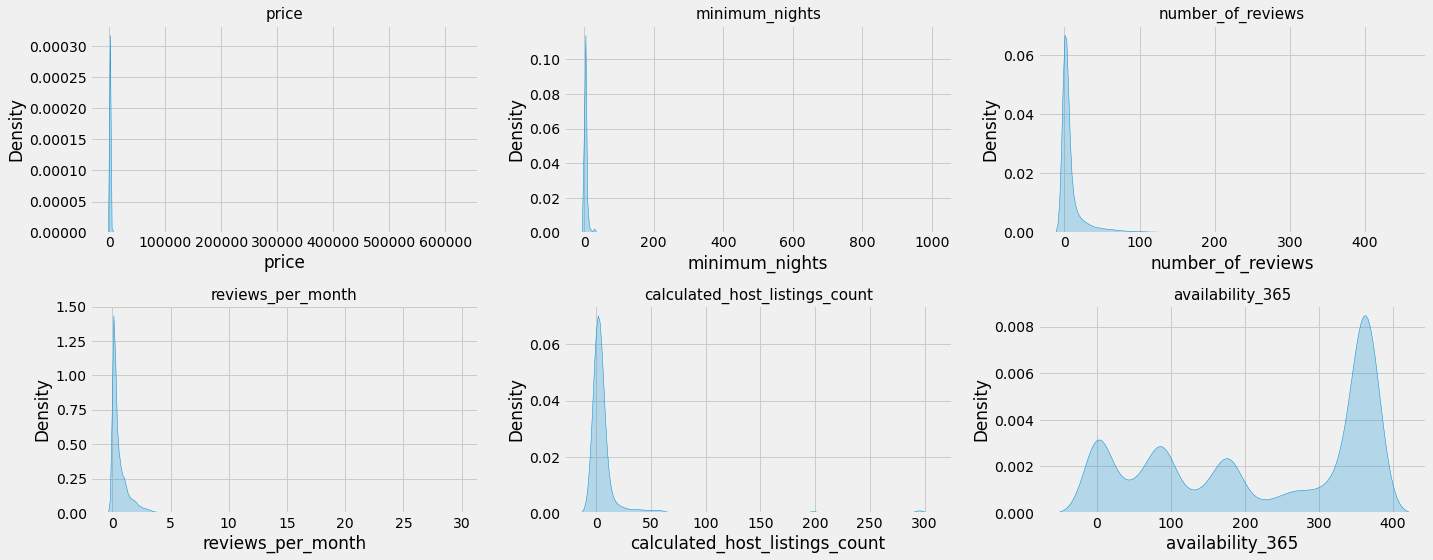

In [6]:
# plotando o gráfico de densidade
# definindo as colunas numéricas
columns_list=['price', 'minimum_nights', 'number_of_reviews', 
                'reviews_per_month', 'calculated_host_listings_count', 'availability_365']

#Vamos criar um subplot com duas linhas e 3 colunas:
nrows = 2
ncols = 3

#Definindo a área da plotagem
fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize=(20,8))
fig.subplots_adjust(hspace=1,wspace=1)

#Criando o loop para a plotagem
idx = 0
for col in columns_list:
    idx += 1
    plt.subplot(nrows, ncols, idx)
    sns.kdeplot(df[col], shade=True)
    plt.title(col, fontsize=15)
plt.tight_layout()

Dentre as variáveis plotadas, apenas a availability_365 tem uma variação mais bem distribuida, sem uma percepção de prováveis outliers. Na nossa variável target, price, percebemos outliers muito distantes da maior porção dos dados

Vamos entender melhor os nosso dados, através de uma análise descritiva

In [7]:
# verificando as principais estatísticas numéricas
df[columns_list].describe()

price  minimum_nights  number_of_reviews  reviews_per_month  \
count   26615.000000    26615.000000       26615.000000       16657.000000   
mean      742.589254        4.725268          12.146308           0.629190   
std      5368.868834       19.102522          29.722813           0.876064   
min         0.000000        1.000000           0.000000           0.010000   
25%       157.000000        1.000000           0.000000           0.090000   
50%       280.000000        2.000000           2.000000           0.270000   
75%       550.000000        4.000000           9.000000           0.850000   
max    625216.000000     1000.000000         446.000000          29.530000   

       calculated_host_listings_count  availability_365  
count                    26615.000000      26615.000000  
mean                         9.665414        219.438174  
std                         35.942124        141.525405  
min                          1.000000          0.000000  
25%                          1.000000         88.000000  
50%                          1.000000        254.000000  
75%                          3.000000        363.000000  
max                        295.000000        365.000000

Agora podemos ver mais claramente a dimensão dos valores em relação as suas distribuições. A nossa variável target por exemplo, tem 75% dos valor até 550 e o máximo dessa mesmoa variável é 625.216. Um valor muito fora do resto da distribuição dos dados dessa variável.

In [8]:
df.describe(include='O')

name host_name neighbourhood        room_type
count                       26586     26591         26615            26615
unique                      25807      5145           151                4
top     Apartamento em Copacabana    Daniel    Copacabana  Entire home/apt
freq                           34       312          7712            19285

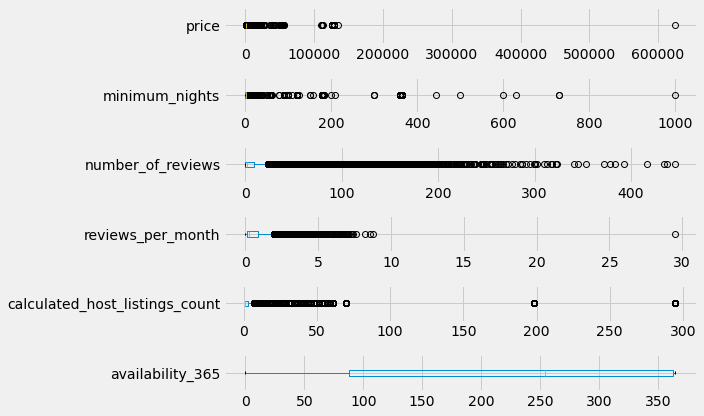

In [9]:
# definindo área de plotagem
fig, ax = plt.subplots(6,1, figsize=(10,6))
# criando loop para plotagem
idx = 0
for col in columns_list:
    idx += 1
    plt.subplot(6,1, idx)
    df[col].plot(kind='box', vert=False)
plt.tight_layout()

Vamos agora tratar os nossos outliers. Vamos definir uma linha de corte pela concentração do volume de dados.

Por exemplo, a nossa variável price, concentra-se até em torno de 550, então definiremos um maixmo até 600.

In [10]:
# reduzindo a quantidade de amostras da variável 'price'
df_opt = df[df['price'] < 600]

In [11]:
df_opt.shape

(20295, 15)

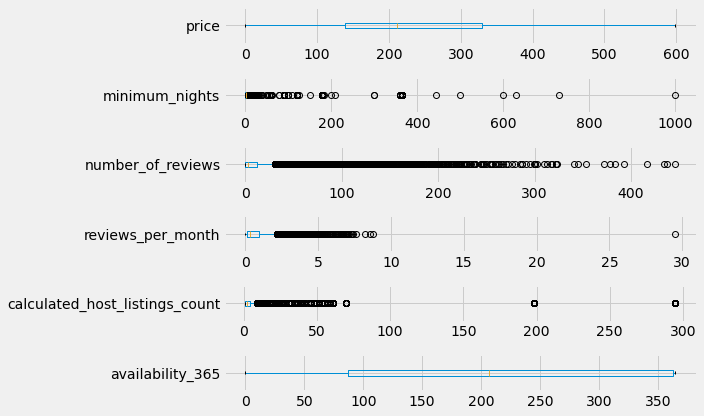

In [12]:
# definindo área de plotagem
fig, ax = plt.subplots(6,1, figsize=(10,6))
# criando loop para plotagem
idx = 0
for col in columns_list:
    idx += 1
    plt.subplot(6,1, idx)
    df_opt[col].plot(kind='box', vert=False)
plt.tight_layout()

Mesmo após reduzirmos o nosso dataframe em 6k linhas. As outras variáveis ainda contém os seus outliers. Vamos aplicar o mesmo processo então para o resto tendo o nosso novo dataframe como base.

Lembrando que, quanto mais cortamos o nosso dataframe, menor é quantidade de dados para treinamento do nosso modelo.

In [13]:

# reduzindo a quantidade de amostras da variável 'minimum_nights'
df_opt = df_opt[df_opt['minimum_nights'] < 8]

# reduzindo a quantidade de amostras da variável 'number_of_reviews'
df_opt = df_opt[df_opt['number_of_reviews'] < 10]

# reduzindo a quantidade de amostras da variável 'reviews_per_month'
#df_opt = df_opt[df_opt['reviews_per_month'] < 7]

# reduzindo a quantidade de amostras da variável 'calculated_host_listings_count'
df_opt = df_opt[df_opt['calculated_host_listings_count'] < 70]

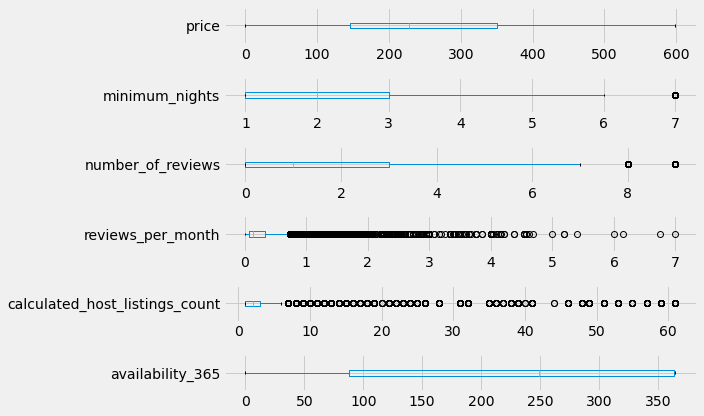

In [14]:
# definindo área de plotagem
fig, ax = plt.subplots(6,1, figsize=(10,6))
# criando loop para plotagem
idx = 0
for col in columns_list:
    idx += 1
    plt.subplot(6,1, idx)
    df_opt[col].plot(kind='box', vert=False)
plt.tight_layout()

In [15]:
df_opt.shape

(13210, 15)

In [16]:
df_opt.head()

name host_id  host_name  \
id                                                                     
48901       Confortable 4BD 3.5BT Atlantic avenue  222884     Marcio   
66574  Beach apart in Rio (January/February 2020)  326301   Frederic   
85807                           Ipanema Copa Flat  470565  Sebastian   
89893             Exotic place in Rio de Janeiro.  483023       Geny   
90907   COPACABANA Best Location! - 3 min from 🏖️  484054    Cleuber   

       neighbourhood_group neighbourhood  latitude  longitude  \
id                                                              
48901                  NaN    Copacabana -22.96574  -43.17514   
66574                  NaN      Flamengo -22.92873  -43.17473   
85807                  NaN    Copacabana -22.98525  -43.19247   
89893                  NaN   Laranjeiras -22.94286  -43.19356   
90907                  NaN    Copacabana -22.97839  -43.19108   

             room_type  price  minimum_nights  number_of_reviews last_review  \
id                                                                             
48901  Entire home/apt    540               4                  4  2020-03-08   
66574  Entire home/apt    180               4                  1  2016-08-24   
85807  Entire home/apt    149               2                  4  2020-10-12   
89893     Private room    491               1                  0         NaT   
90907  Entire home/apt    197               2                  2  2019-12-29   

       reviews_per_month  calculated_host_listings_count  availability_365  
id                                                                          
48901               0.06                               2                 1  
66574               0.02                               1               356  
85807               0.29                               6               285  
89893                NaN                               1               365  
90907               0.13                               1               267

In [17]:
#Removenndo a coluna sem dados
df_opt.drop('neighbourhood_group', axis=1, inplace=True)

In [18]:
df_opt.shape

(13210, 14)

Vamos plotar um mapa baseado nas nossas informações de lat e long pela biblioteca plotly com o open-street-map

In [19]:
#plotando mapa
fig = px.scatter_mapbox(df_opt, lat='latitude', lon='longitude', hover_name='name', color_discrete_sequence=['red'],
                       zoom=10, height=500)
fig.update_layout(mapbox_style='open-street-map')
fig.update_layout(margin={'r':0,'t':0,'l':0,'b':0})
fig.show()